<a href="https://colab.research.google.com/github/SteepDay/neural_networks/blob/main/resnet_cifar10_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Отображатель графиков обучения

In [1]:
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output
from tensorflow.keras import backend as K

class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.inter_dim = []
        self.val_inter_dim = []
        self.logits = []
        self.val_logits = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        self.i += 1
        f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

        clear_output(wait=True)

        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss:" +
                 str(round(logs.get('loss'), 2)))
        ax1.plot(self.x, self.val_losses, label="v_loss:" +
                 str(round(logs.get('val_loss'), 2)))
        ax1.legend()

        ax2.plot(self.x, self.acc, label="acc:" +
                 str(round(logs.get('accuracy'), 2)))
        ax2.plot(self.x, self.val_acc, label="v_acc:" +
                 str(round(logs.get('val_accuracy'), 2)))
        ax2.legend()

        plt.savefig("fig")
        plt.show()

plot = PlotLearning()

Загрузка и подготовка данных

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


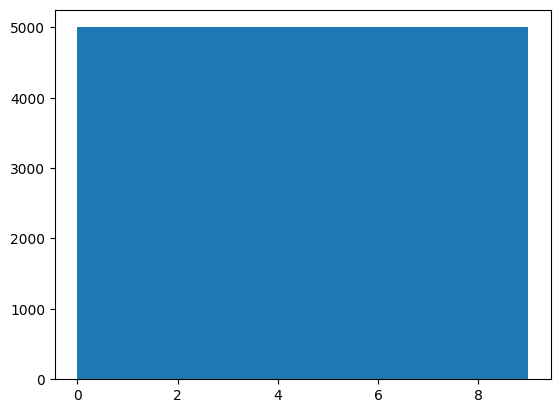

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [2]:
from __future__ import print_function
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
import os
import tensorflow.keras as keras
import numpy as np

num_classes = 10
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_cnn_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

plt.hist(y_train, num_classes)
plt.show()

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

Нормализация данных

In [3]:
x_train /= 255
x_test /= 255

Определение ResNet блока

In [4]:
import tensorflow as tf
class ResnetIdentityBlock(tf.keras.Model):
  def __init__(self, filters):
    super(ResnetIdentityBlock, self).__init__()
    self.filters = filters
    filters1, filters3 = filters

    self.conv2a = tf.keras.layers.Conv2D(filters1, (3, 3), padding='same')
    self.bn2a = tf.keras.layers.BatchNormalization()

    self.conv2c = tf.keras.layers.Conv2D(filters3, (3, 3), padding='same')
    self.bn2c = tf.keras.layers.BatchNormalization()

  def call(self, input_tensor, training=False):
    x = self.conv2a(input_tensor)
    x = self.bn2a(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv2c(x)
    x = self.bn2c(x, training=training)

    x += input_tensor
    return tf.nn.relu(x)

  def get_config(self):
    config = super(ResnetIdentityBlock, self).get_config()
    config.update({"filters": self.filters})
    return config

Создание модели

In [5]:
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, ReLU, PReLU, InputLayer
from tensorflow.keras import regularizers
from tensorflow.keras.applications.resnet50 import ResNet50

model = Sequential()

# Первый сверточный блок с увеличенным количеством фильтров
model.add(Conv2D(32, (3,3), input_shape=(32,32,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)))
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Уменьшено количество ResNet блоков с 5 до 3 в каждом разделе
for i in range(3):
    resnet_block = ResnetIdentityBlock([32, 32])
    model.add(resnet_block)

# Второй сверточный блок с MaxPooling вместо stride
model.add(Conv2D(64, (3,3), padding='same'))
model.add(ReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

for i in range(3):
    resnet_block = ResnetIdentityBlock([64, 64])
    model.add(resnet_block)

# Третий сверточный блок
model.add(Conv2D(128, (3,3), padding='same'))
model.add(ReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.4))

for i in range(3):
    resnet_block = ResnetIdentityBlock([128, 128])
    model.add(resnet_block)

# Финальные слои
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(1e-4)))
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Измененный оптимизатор с уменьшенным learning rate
opt = keras.optimizers.Adam(learning_rate=0.0005)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_identity_block           │ (None, 32, 32, 32)     │        18,752 │
│ (ResnetIdentityBlock)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_identity_block_1         │ (None, 32, 32, 32)     │        18,752 │
│ (ResnetIdentityBlock)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_identity_block_2         │ (None, 32, 32, 32)     │        18,752 │
│ (ResnetIdentityBlock)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_identity_block_3         │ (None, 16, 16, 64)     │        74,368 │
│ (ResnetIdentityBlock)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_identity_block_4         │ (None, 16, 16, 64)     │        74,368 │
│ (ResnetIdentityBlock)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_identity_block_5         │ (None, 16, 16, 64)     │        74,368 │
│ (ResnetIdentityBlock)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,312,586 (8.82 MB)

 Trainable params: 2,309,194 (8.81 MB)

 Non-trainable params: 3,392 (13.25 KB)

Обучение модели с аугментацией данных

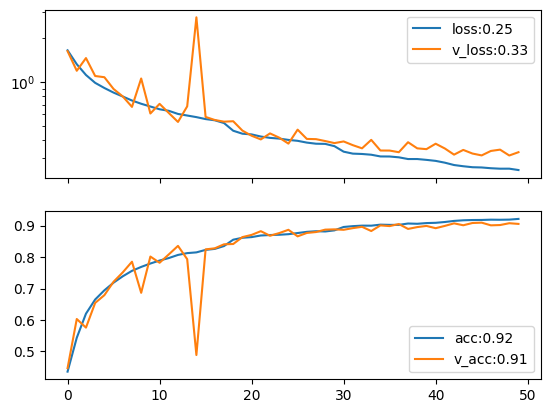

391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 99ms/step - accuracy: 0.9206 - loss: 0.2517 - val_accuracy: 0.9052 - val_loss: 0.3306 - learning_rate: 6.2500e-05


In [7]:
print('Using data augmentation.')
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.1,
    fill_mode='nearest')

batch_size = 128
epochs = 50


reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=1e-6, verbose=1)

model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
          epochs=epochs,
          validation_data=(x_test, y_test),
          callbacks=[plot, reduce_lr],
          verbose=1)

Визуализация результатов классификации

          GT class           Predicted class


<ipython-input-8-d7ef7c5af921>:16: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  fig = plt.figure(1, (4., 4.))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


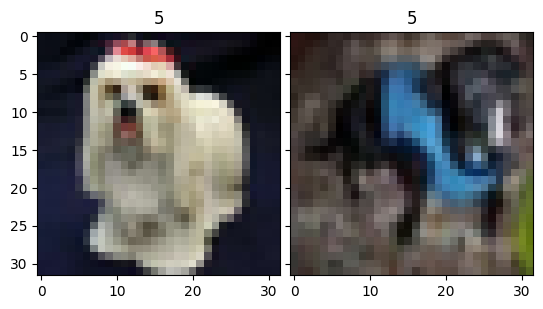

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


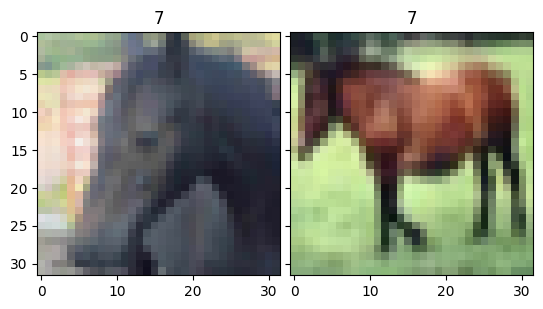

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


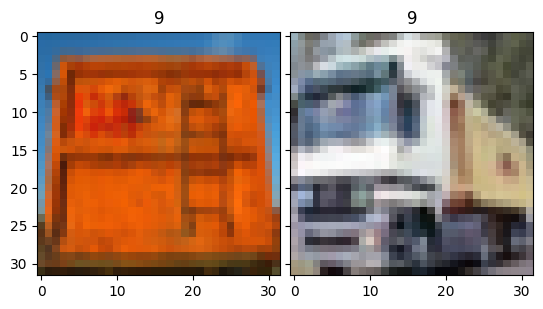

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


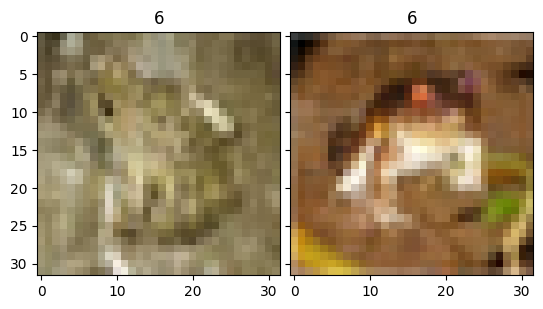

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


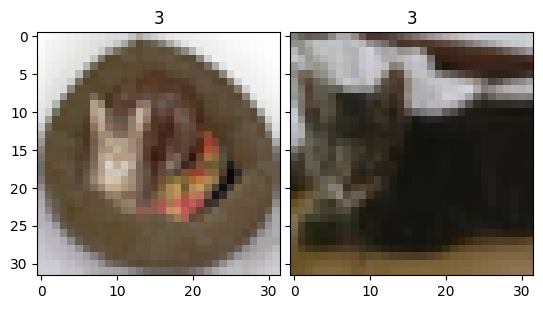

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


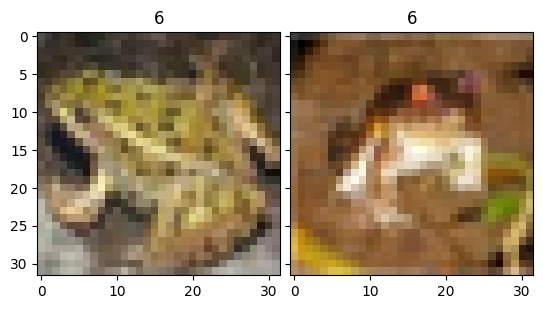

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


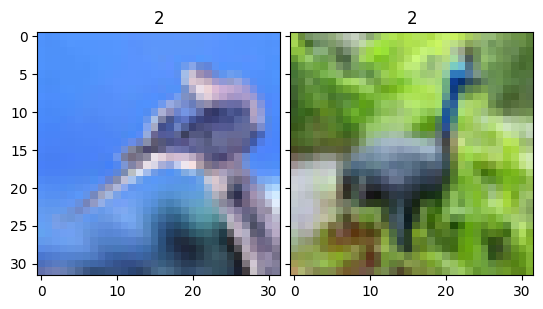

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


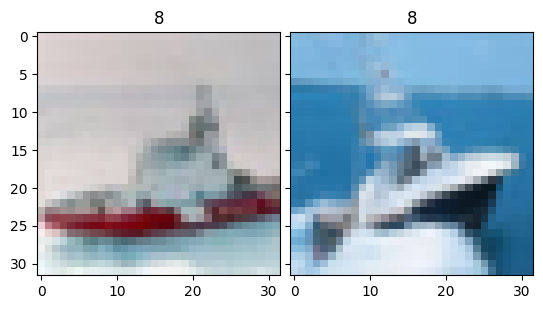

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


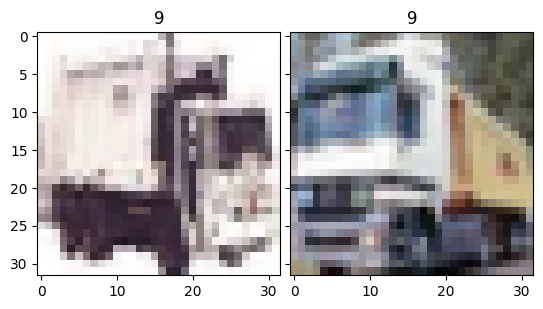

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


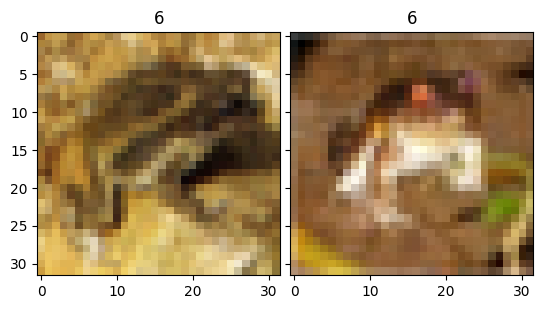

In [8]:
from matplotlib.colors import Colormap
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

def get_class_sample(cls_index):
    for i in range(len(y_train)):
        if np.argmax(y_train[i]) == cls_index:
            return x_train[i]
    return None

print("          GT class           Predicted class")

for i in range(10):
    plt.set_cmap(Colormap("Greys"))
    fig = plt.figure(1, (4., 4.))
    grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 2),
                 axes_pad=0.1,
                 )

    images = []
    np_images = []
    k = random.randint(0,len(x_test)-1)
    images.append(np.expand_dims(x_test[k], axis=0))
    np_images = np.vstack(images)
    y = model.predict(np_images)

    c = np.argmax(y[0])

    cls_name_pred = c
    cls_name_gt = np.argmax(y_test[k])

    img = x_test[k]
    img_pred = get_class_sample(cls_name_pred)
    grid[0].imshow(np.reshape(img,(32,32,3)))
    grid[0].set_title("{}".format(cls_name_gt))
    grid[1].imshow(np.reshape(img_pred,(32,32,3)))
    grid[1].set_title("{}".format(cls_name_pred))

    plt.show()

Построение матрицы ошибок

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

<Axes: >

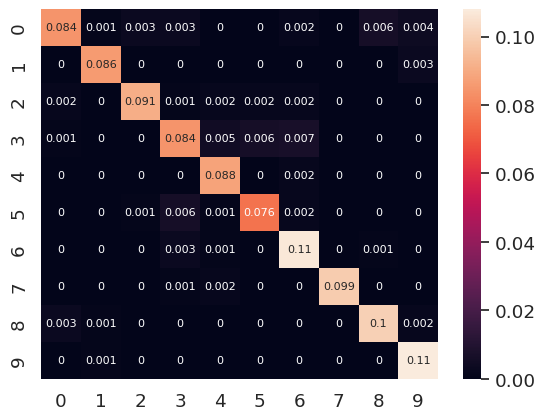

In [9]:
import pandas as pd
import seaborn as sn

def get_conf_matrix(x_test, y_test):
    m = np.zeros((10,10))
    acc = 0
    i = 0
    for x in x_test:
        yp = np.argmax(model.predict(np.expand_dims(x, axis=0)))
        m[np.argmax(y_test[i]),yp] += 1
        i = i+1
    m = m/len(y_test)

    return m

m = get_conf_matrix(x_test[:1000], y_test[:1000])
df_cm = pd.DataFrame(m, range(10), range(10))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8})

Классификация произвольного изображения

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
frog.PNG
(1130, 1997, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.00301273 0.00279579 0.6381863  0.01527131 0.06424113 0.00109628
  0.2714045  0.00088447 0.00069637 0.0024112 ]]


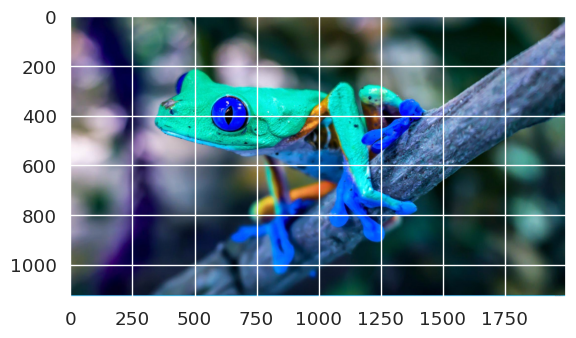

In [11]:
import cv2
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/datasets

img = cv2.imread("/content/drive/MyDrive/datasets/frog.PNG")
print(img.shape)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img = img[...,::-1]
img = cv2.resize(img,(32,32))
img = img.astype("float32")/255
y = model.predict(np.expand_dims(img,0))
print(y)